In [40]:
import os
import imageio
import pickle
import pandas as pd
import numpy as np
import PyNAFF as pnf
import scipy.io as sio 
import matplotlib.cm as cm
from math import log10, floor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

In [98]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

## Function declarations

In [85]:
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)  

In [3]:
########################################################################
# Read PTC Twiss and return dictionary of columns/values
########################################################################
def Read_PTC_Twiss_Return_Dict(filename, verbose=True):
    # Dictionary for output
    d = dict()
    d['HEADER_FILENAME'] = [filename]
    keywords = ''
    
    # First we open and count header lines
    fin0=open(filename,'r').readlines()
    headerlines = 0
    for l in fin0:
        # Store each header line
        headerlines = headerlines + 1
        # Stop if we find the line starting '* NAME'
        if '* NAME' in l:
            keywords = l
            break
        # Store the headers as d['HEADER_<name>'] = <value>
        else:
            #try:
            #    d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]     
            #except ValueError:
            #    d[str('HEADER_'+l.split()[1])]=[str(l.split()[-1])]   
            if '"' in l:
                d[str('HEADER_'+l.split()[1])]=[str(l.split('"')[1])]
            else:
                d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]                 
    headerlines = headerlines + 1    
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict found Keywords: \n',keywords
    
    # Make a list of column keywords to return (as an aid to iterating)
    dict_keys = []
    for key in keywords.split():
        dict_keys.append(key)
    dict_keys.remove('*')
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict Dict Keys: \n',dict_keys
    
    # Initialise empty dictionary entries for column keywords 
    for key in dict_keys:
        d[key]=[]
        
    if verbose: 
        print '\nRead_PTC_Twiss_Return_Dict header only dictionary \n'
        for i in d:
            print i, d[i]
    
    # Strip header
    fin1=open(filename,'r').readlines()[headerlines:]   
    
    # Populate the dictionary line by line
    for l in fin1:
        i = -1        
        for value in l.split():
            i = i+1
            if 'NAME' in dict_keys[i]:
                d[dict_keys[i]].append(str(value))
            else:
                d[dict_keys[i]].append(float(value))    
                
    # Return list of column keywords 'dict_keys', and dictionary 'd'
    return dict_keys, d

In [4]:
def return_initial_Parameter(d, parameter, sig_limit=3):
    return d[parameter][0] 

def print_Twiss_Dict_Parameter(d, parameter, sig_limit=3):
    print parameter, ' = ', round_sig(d[parameter][0],sig_limit) 

def print_Twiss_Dict_Tunes(d, sig_limit=3):
    print '(Qx, Qy) = (', round_sig(d['HEADER_Q1'][0],sig_limit) , ',' , round_sig(d['HEADER_Q2'][0],sig_limit) , ')'
    

In [5]:
def harmonic_fn(x, a, b, c, d):
    return a + b*np.cos(c + 2*np.pi*d*x)

In [6]:
def quadratic(x, a, m, c):
    return a*x**2 + x*m + c

In [7]:
def cubic(x, a, m, c, b):
    return a*x**2 + x*m + c + b*x**3

In [8]:
def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)

In [9]:
def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

In [10]:
def round_sig(x, sig=4):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [11]:
def add_input_file(dd, filename, label, verbose=True):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	if verbose: print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [12]:
def is_non_zero_file(fpath, verbose=True):  
	if verbose: print '\t\tis_non_zero_file:: Checking file ', fpath
	if verbose: print '\t\tis_non_zero_file:: File exists = ', os.path.isfile(fpath)
	if verbose: print '\t\tis_non_zero_file:: Size > 3 bytes = ', os.path.getsize(fpath)
	return os.path.isfile(fpath) and os.path.getsize(fpath) > 3

In [13]:
def make_dispersion_vector_dict(d, bunch_output_dir, verbose=True):
    maxi = 30
    turns = range(0,maxi)   
    
    for t in turns:
        if t <= 9: inputs = str(bunch_output_dir +'/bunch_output/mainbunch_00000' + str(int(t)) + '.mat')
        else:      inputs = str(bunch_output_dir +'/bunch_output/mainbunch_0000' + str(int(t)) + '.mat' )
        
        if verbose: print '\nInput file location: ', inputs
            
        if is_non_zero_file(inputs, verbose):            
            d = add_input_file(d, inputs, (t+1), verbose=verbose)
        else:
            print 'make_dispersion_vector_dict:: input file does not exist'
            exit(0)
            
    d = add_input_file(d, str(bunch_output_dir +'/bunch_output/mainbunch_-000001.mat'), 0, verbose=verbose)
    return d    

In [14]:
def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

In [15]:
PTC_gamma = 2.49038064
beta = LorentzBeta(PTC_gamma)
E = 2336654575.29 * 1E-9 
beta

0.9158392756488949

## Load dispersion vector data

In [16]:
d0_H_07 = dict()
d0_H_07 = make_dispersion_vector_dict(d0_H_07, '0_H_07', verbose=False)

d0_H_08 = dict()
d0_H_08 = make_dispersion_vector_dict(d0_H_08, '0_H_08', verbose=False)

d0_H_09 = dict()
d0_H_09 = make_dispersion_vector_dict(d0_H_09, '0_H_09', verbose=False)

d0_H_10 = dict()
d0_H_10 = make_dispersion_vector_dict(d0_H_10, '0_H_10', verbose=False)

d0_H_11 = dict()
d0_H_11 = make_dispersion_vector_dict(d0_H_11, '0_H_11', verbose=False)

d0_H_12 = dict()
d0_H_12 = make_dispersion_vector_dict(d0_H_12, '0_H_12', verbose=False)

d0_H_13 = dict()
d0_H_13 = make_dispersion_vector_dict(d0_H_13, '0_H_13', verbose=False)

d0_H_14 = dict()
d0_H_14 = make_dispersion_vector_dict(d0_H_14, '0_H_14', verbose=False)

d0_H_15 = dict()
d0_H_15 = make_dispersion_vector_dict(d0_H_15, '0_H_15', verbose=False)

d0_H_16 = dict()
d0_H_16 = make_dispersion_vector_dict(d0_H_16, '0_H_16', verbose=False)

d0_H_17 = dict()
d0_H_17 = make_dispersion_vector_dict(d0_H_17, '0_H_17', verbose=False)

d0_H_18 = dict()
d0_H_18 = make_dispersion_vector_dict(d0_H_18, '0_H_18', verbose=False)

d0_H_19 = dict()
d0_H_19 = make_dispersion_vector_dict(d0_H_19, '0_H_19', verbose=False)

d0_H_20 = dict()
d0_H_20 = make_dispersion_vector_dict(d0_H_20, '0_H_20', verbose=False)

d0_H_21 = dict()
d0_H_21 = make_dispersion_vector_dict(d0_H_21, '0_H_21', verbose=False)

H_No_Mismatch = [d0_H_07, d0_H_08, d0_H_09, d0_H_10, d0_H_11, d0_H_12, d0_H_13, d0_H_14, d0_H_15, d0_H_16, d0_H_17, d0_H_18, d0_H_19, d0_H_20, d0_H_21]

In [17]:
d1_H_07 = dict()
d1_H_07 = make_dispersion_vector_dict(d1_H_07, '1_H_07', verbose=False)

d1_H_08 = dict()
d1_H_08 = make_dispersion_vector_dict(d1_H_08, '1_H_08', verbose=False)

d1_H_09 = dict()
d1_H_09 = make_dispersion_vector_dict(d1_H_09, '1_H_09', verbose=False)

d1_H_10 = dict()
d1_H_10 = make_dispersion_vector_dict(d1_H_10, '1_H_10', verbose=False)

d1_H_11 = dict()
d1_H_11 = make_dispersion_vector_dict(d1_H_11, '1_H_11', verbose=False)

d1_H_12 = dict()
d1_H_12 = make_dispersion_vector_dict(d1_H_12, '1_H_12', verbose=False)

d1_H_13 = dict()
d1_H_13 = make_dispersion_vector_dict(d1_H_13, '1_H_13', verbose=False)

d1_H_14 = dict()
d1_H_14 = make_dispersion_vector_dict(d1_H_14, '1_H_14', verbose=False)

d1_H_15 = dict()
d1_H_15 = make_dispersion_vector_dict(d1_H_15, '1_H_15', verbose=False)

d1_H_16 = dict()
d1_H_16 = make_dispersion_vector_dict(d1_H_16, '1_H_16', verbose=False)

d1_H_17 = dict()
d1_H_17 = make_dispersion_vector_dict(d1_H_17, '1_H_17', verbose=False)

d1_H_18 = dict()
d1_H_18 = make_dispersion_vector_dict(d1_H_18, '1_H_18', verbose=False)

d1_H_19 = dict()
d1_H_19 = make_dispersion_vector_dict(d1_H_19, '1_H_19', verbose=False)

d1_H_20 = dict()
d1_H_20 = make_dispersion_vector_dict(d1_H_20, '1_H_20', verbose=False)

d1_H_21 = dict()
d1_H_21 = make_dispersion_vector_dict(d1_H_21, '1_H_21', verbose=False)

H_Mismatch = [d1_H_07, d1_H_08, d1_H_09, d1_H_10, d1_H_11, d1_H_12, d1_H_13, d1_H_14, d1_H_15, d1_H_16, d1_H_17, d1_H_18, d1_H_19, d1_H_20, d1_H_21]

In [18]:
d0_V_10 = dict()
d0_V_10 = make_dispersion_vector_dict(d0_V_10, '0_V_10', verbose=False)

d0_V_11 = dict()
d0_V_11 = make_dispersion_vector_dict(d0_V_11, '0_V_11', verbose=False)

d0_V_12 = dict()
d0_V_12 = make_dispersion_vector_dict(d0_V_12, '0_V_12', verbose=False)

d0_V_13 = dict()
d0_V_13 = make_dispersion_vector_dict(d0_V_13, '0_V_13', verbose=False)

d0_V_14 = dict()
d0_V_14 = make_dispersion_vector_dict(d0_V_14, '0_V_14', verbose=False)

d0_V_15 = dict()
d0_V_15 = make_dispersion_vector_dict(d0_V_15, '0_V_15', verbose=False)

d0_V_16 = dict()
d0_V_16 = make_dispersion_vector_dict(d0_V_16, '0_V_16', verbose=False)

d0_V_17 = dict()
d0_V_17 = make_dispersion_vector_dict(d0_V_17, '0_V_17', verbose=False)

d0_V_18 = dict()
d0_V_18 = make_dispersion_vector_dict(d0_V_18, '0_V_18', verbose=False)

d0_V_19 = dict()
d0_V_19 = make_dispersion_vector_dict(d0_V_19, '0_V_19', verbose=False)

d0_V_20 = dict()
d0_V_20 = make_dispersion_vector_dict(d0_V_20, '0_V_20', verbose=False)

d0_V_21 = dict()
d0_V_21 = make_dispersion_vector_dict(d0_V_21, '0_V_21', verbose=False)

d0_V_22 = dict()
d0_V_22 = make_dispersion_vector_dict(d0_V_22, '0_V_22', verbose=False)

d0_V_23 = dict()
d0_V_23 = make_dispersion_vector_dict(d0_V_23, '0_V_23', verbose=False)

d0_V_24 = dict()
d0_V_24 = make_dispersion_vector_dict(d0_V_24, '0_V_24', verbose=False)

V_No_Mismatch = [d0_V_10, d0_V_11, d0_V_12, d0_V_13, d0_V_14, d0_V_15, d0_V_16, d0_V_17, d0_V_18, d0_V_19, d0_V_20, d0_V_21, d0_V_22, d0_V_23, d0_V_24 ]

In [19]:
d1_V_10 = dict()
d1_V_10 = make_dispersion_vector_dict(d1_V_10, '1_V_10', verbose=False)

d1_V_11 = dict()
d1_V_11 = make_dispersion_vector_dict(d1_V_11, '1_V_11', verbose=False)

d1_V_12 = dict()
d1_V_12 = make_dispersion_vector_dict(d1_V_12, '1_V_12', verbose=False)

d1_V_13 = dict()
d1_V_13 = make_dispersion_vector_dict(d1_V_13, '1_V_13', verbose=False)

d1_V_14 = dict()
d1_V_14 = make_dispersion_vector_dict(d1_V_14, '1_V_14', verbose=False)

d1_V_15 = dict()
d1_V_15 = make_dispersion_vector_dict(d1_V_15, '1_V_15', verbose=False)

d1_V_16 = dict()
d1_V_16 = make_dispersion_vector_dict(d1_V_16, '1_V_16', verbose=False)

d1_V_17 = dict()
d1_V_17 = make_dispersion_vector_dict(d1_V_17, '1_V_17', verbose=False)

d1_V_18 = dict()
d1_V_18 = make_dispersion_vector_dict(d1_V_18, '1_V_18', verbose=False)

d1_V_19 = dict()
d1_V_19 = make_dispersion_vector_dict(d1_V_19, '1_V_19', verbose=False)

d1_V_20 = dict()
d1_V_20 = make_dispersion_vector_dict(d1_V_20, '1_V_20', verbose=False)

d1_V_21 = dict()
d1_V_21 = make_dispersion_vector_dict(d1_V_21, '1_V_21', verbose=False)

d1_V_22 = dict()
d1_V_22 = make_dispersion_vector_dict(d1_V_22, '1_V_22', verbose=False)

d1_V_23 = dict()
d1_V_23 = make_dispersion_vector_dict(d1_V_23, '1_V_23', verbose=False)

d1_V_24 = dict()
d1_V_24 = make_dispersion_vector_dict(d1_V_24, '1_V_24', verbose=False)

V_Mismatch = [d1_V_10, d1_V_11, d1_V_12, d1_V_13, d1_V_14, d1_V_15, d1_V_16, d1_V_17, d1_V_18, d1_V_19, d1_V_20, d1_V_21, d1_V_22, d1_V_23, d1_V_24 ]

## Load PTC Twiss

In [20]:
LEQ_H_07_keys, LEQ_H_07 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_07.tfs')
LEQ_H_08_keys, LEQ_H_08 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_08.tfs')
LEQ_H_09_keys, LEQ_H_09 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_09.tfs')
LEQ_H_10_keys, LEQ_H_10 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_10.tfs')
LEQ_H_11_keys, LEQ_H_11 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_11.tfs')
LEQ_H_12_keys, LEQ_H_12 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_12.tfs')
LEQ_H_13_keys, LEQ_H_13 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_13.tfs')
LEQ_H_14_keys, LEQ_H_14 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_14.tfs')
LEQ_H_15_keys, LEQ_H_15 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_15.tfs')
LEQ_H_16_keys, LEQ_H_16 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_16.tfs')
LEQ_H_17_keys, LEQ_H_17 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_17.tfs')
LEQ_H_18_keys, LEQ_H_18 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_18.tfs')
LEQ_H_19_keys, LEQ_H_19 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_19.tfs')
LEQ_H_20_keys, LEQ_H_20 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_20.tfs')
LEQ_H_21_keys, LEQ_H_21 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_21.tfs')
LEQ_H_List = [LEQ_H_07, LEQ_H_08, LEQ_H_09, LEQ_H_10, LEQ_H_11, LEQ_H_12, LEQ_H_13, LEQ_H_14, LEQ_H_15, LEQ_H_16, LEQ_H_17, LEQ_H_18, LEQ_H_19, LEQ_H_20, LEQ_H_21]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1329643408]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [10.01946085]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [24.15254239]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02827408041]
HEADER_BETA_X_MAX [29.23376144]
HEADER_BETA_X_MIN [10.01946085]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1336149557]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.14172139]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [23.65778001]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02762346547]
HEADER_BETA_X_MAX [25.30280686]
HEADER_BETA_X_MIN [11.14172139]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_PXCOMIN [0.0]
HEADER_PYCORMS [0.0]
X []
HEADER_PARTICLE ['PROTON']
HEADER_KBUNCH [1.0]
HEADER_PTCORMS [0.0]
HEADER_GAMMA_TR [6.064487935]
HEADER_ORBIT_PT [0.0]
HEADER_BETA33MAX [0.0]
HEADER_BETA12MAX [0.0]
HEADER_ORBIT_PX [0.0]
HEADER_ORBIT_PY [0.0]
HEADER_PTCOMAX [0.0]
HEADER_BETA32MIN [0.0]
HEADER_BETA31MAX [0.0]
HEADER_TCORMS [0.0]
HEADER_BETA32MAX [0.0]
HEADER_DISP2MAX [0.40340043]
HEADER_XCORMS [0.0]
HEADER_DATE ['17/08/20']
HEADER_DISP2MIN [-0.4033830443]
HEADER_BCURRENT [0.0]
HEADER_Q1 [0.1895105486]
HEADER_Q2 [0.2401225753]
HEADER_BETA22MIN [11.49941997]
PX []
PY []
HEADER_PTCOMIN [0.0]
HEADER_GAMMA [2.49038064]
HEADER_DISP3MAX [0.0]
HEADER_QS [0.0]
S []
HEADER_BETA21MIN [0.0]
HEADER_BETA_Y_MAX [23.33083281]
HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.49941997]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.630857659]
HEADER_YCORMS [0.0]
HEADER_BETA23MIN [0.0]
HEADER_ORBIT_Y [0.0

In [21]:
for d in LEQ_H_List:
    print_Twiss_Dict_Tunes(d,2)

(Qx, Qy) = ( 0.07 , 0.24 )
(Qx, Qy) = ( 0.08 , 0.24 )
(Qx, Qy) = ( 0.09 , 0.24 )
(Qx, Qy) = ( 0.1 , 0.24 )
(Qx, Qy) = ( 0.11 , 0.24 )
(Qx, Qy) = ( 0.12 , 0.24 )
(Qx, Qy) = ( 0.13 , 0.24 )
(Qx, Qy) = ( 0.14 , 0.24 )
(Qx, Qy) = ( 0.15 , 0.24 )
(Qx, Qy) = ( 0.16 , 0.24 )
(Qx, Qy) = ( 0.17 , 0.24 )
(Qx, Qy) = ( 0.18 , 0.24 )
(Qx, Qy) = ( 0.19 , 0.24 )
(Qx, Qy) = ( 0.2 , 0.24 )
(Qx, Qy) = ( 0.21 , 0.24 )


In [22]:
LEQ_V_10_keys, LEQ_V_10 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_10.tfs')
LEQ_V_11_keys, LEQ_V_11 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_11.tfs')
LEQ_V_12_keys, LEQ_V_12 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_12.tfs')
LEQ_V_13_keys, LEQ_V_13 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_13.tfs')
LEQ_V_14_keys, LEQ_V_14 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_14.tfs')
LEQ_V_15_keys, LEQ_V_15 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_15.tfs')
LEQ_V_16_keys, LEQ_V_16 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_16.tfs')
LEQ_V_17_keys, LEQ_V_17 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_17.tfs')
LEQ_V_18_keys, LEQ_V_18 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_18.tfs')
LEQ_V_19_keys, LEQ_V_19 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_19.tfs')
LEQ_V_20_keys, LEQ_V_20 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_20.tfs')
LEQ_V_21_keys, LEQ_V_21 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_21.tfs')
LEQ_V_22_keys, LEQ_V_22 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_22.tfs')
LEQ_V_23_keys, LEQ_V_23 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_23.tfs')
LEQ_V_24_keys, LEQ_V_24 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_24.tfs')
LEQ_V_List = [LEQ_V_10, LEQ_V_11, LEQ_V_12, LEQ_V_13, LEQ_V_14, LEQ_V_15, LEQ_V_16, LEQ_V_17, LEQ_V_18, LEQ_V_19, LEQ_V_20, LEQ_V_21, LEQ_V_22, LEQ_V_23, LEQ_V_24]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342599162]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.04248161]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [28.94231883]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02697850494]
HEADER_BETA_X_MAX [24.54387774]
HEADER_BETA_X_MIN [11.04248161]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_Q2 [0.1501335359]
HEADER_BETA22MIN [11.09318912]
PX []
PY []
HEADER_PTCOMIN [0.0]
HEADER_GAMMA [2.49038064]
HEADER_DISP3MAX [0.0]
HEADER_QS [0.0]
S []
HEADER_BETA21MIN [0.0]
HEADER_BETA_Y_MAX [26.01049269]
HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.09318912]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.624110803]
HEADER_YCORMS [0.0]
HEADER_BETA23MIN [0.0]
HEADER_ORBIT_Y [0.0]
HEADER_ORBIT_X [0.0]
HEADER_EX [1.0]
HEADER_EY [1.0]
HEADER_ET [1.0]
BETY []
BETX []
HEADER_XCOMIN [0.0]
HEADER_YCOMIN [0.0]
ALFY []
ALFX []
HEADER_BETA23MAX [0.0]
MU1 []
NAME []
MU2 []
HEADER_TYPE ['TWISS']
HEADER_FILENAME ['../PTC_Twiss/V_15.tfs']
HEADER_YCOMAX [0.0]
HEADER_XCOMAX [0.0]
HEADER_TIME ['09.41.20']
HEADER_SIGT [0.0]
HEADER_DISP3MIN [0.0]
HEADER_ORBIT_-CT [0.0]
HEADER_DQ2 [-7.783319611]
HEADER_DQ1 [-5.720966098]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADE


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342268494]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.43185331]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [23.96980246]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02701157179]
HEADER_BETA_X_MAX [23.66291917]
HEADER_BETA_X_MIN [11.43185331]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_DQ1 [-5.764661948]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADER_NAME ['PTC_TWISS']
HEADER_PYCOMAX [0.0]
DISP1 []
DISP3 []
DISP2 []
DISP4 []
HEADER_ORIGIN ['MAD-X 5.02.00 Linux 64']
Y []
HEADER_PXCOMAX [0.0]
HEADER_CHARGE [1.0]
HEADER_DISP4MAX [0.0]
HEADER_DISP4MIN [0.0]


In [23]:
for d in LEQ_V_List:
    print_Twiss_Dict_Tunes(d)

(Qx, Qy) = ( 0.21 , 0.1 )
(Qx, Qy) = ( 0.21 , 0.11 )
(Qx, Qy) = ( 0.21 , 0.12 )
(Qx, Qy) = ( 0.21 , 0.13 )
(Qx, Qy) = ( 0.21 , 0.14 )
(Qx, Qy) = ( 0.21 , 0.15 )
(Qx, Qy) = ( 0.21 , 0.16 )
(Qx, Qy) = ( 0.21 , 0.17 )
(Qx, Qy) = ( 0.21 , 0.18 )
(Qx, Qy) = ( 0.21 , 0.19 )
(Qx, Qy) = ( 0.21 , 0.2 )
(Qx, Qy) = ( 0.21 , 0.21 )
(Qx, Qy) = ( 0.21 , 0.22 )
(Qx, Qy) = ( 0.21 , 0.23 )
(Qx, Qy) = ( 0.21 , 0.24 )


# Attempt plotting

In [87]:
test_save_folder = 'Test_Plots'
make_directory(test_save_folder)

Creation of the directory Test_Plots failed


In [24]:
### Access the x data for turn n like:
n = 0
d1_H_07[n]['particles']['x'][0][0][0]

array([-5.16306721e-04,  9.80982771e-03, -1.03261344e-02,  3.29348668e-13,
        1.03261344e-02, -9.80982771e-03,  5.16306722e-04, -9.29352099e-03,
        1.03261344e-03, -8.77721427e-03,  1.54892017e-03, -8.26090755e-03,
        2.06522689e-03, -7.74460083e-03,  2.58153361e-03, -7.22829411e-03,
        3.09784033e-03, -6.71198738e-03,  3.61414705e-03, -6.19568066e-03,
        4.13045377e-03, -5.67937394e-03,  4.64676050e-03, -5.16306722e-03,
        5.16306722e-03, -4.64676050e-03,  5.67937394e-03, -4.13045377e-03,
        6.19568066e-03, -3.61414705e-03,  6.71198738e-03, -3.09784033e-03,
        7.22829411e-03, -2.58153361e-03,  7.74460083e-03, -2.06522689e-03,
        8.26090755e-03, -1.54892017e-03,  8.77721427e-03, -1.03261344e-03,
        9.29352099e-03])

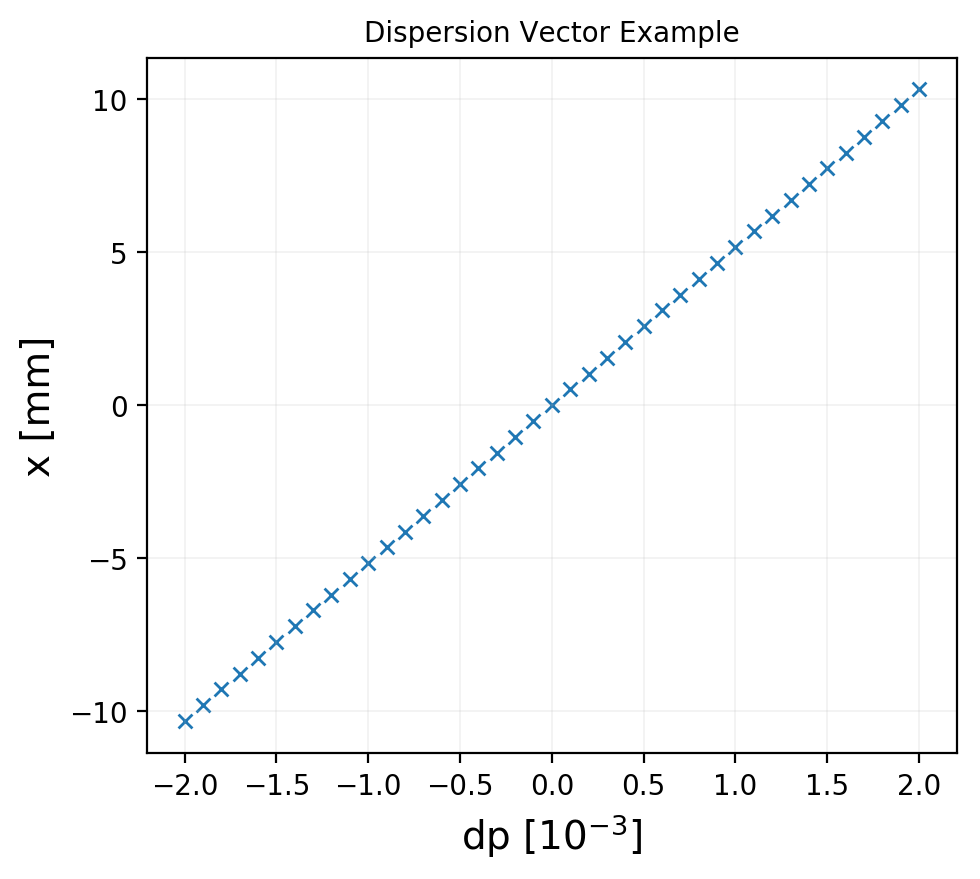

In [99]:
### Our dispersion vector can be plotted like:
n = 0;
fig1, ax1 = plt.subplots(1, tight_layout=True);

parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;

ax1.set_title('Dispersion Vector Example');
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(linewidth=0.1);
#ax1.set_ylim(-15, 15);

x = np.array(multi1 * d1_H_07[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
y = np.array(multi2 * d1_H_07[n]['particles'][parameter2][0][0][0])

ax1.scatter(x, y, marker='x');

savename = test_save_folder +'/Dispersion_Vector_Example.png'
plt.savefig(savename);

Fitted linear dispersion =  5.163  m


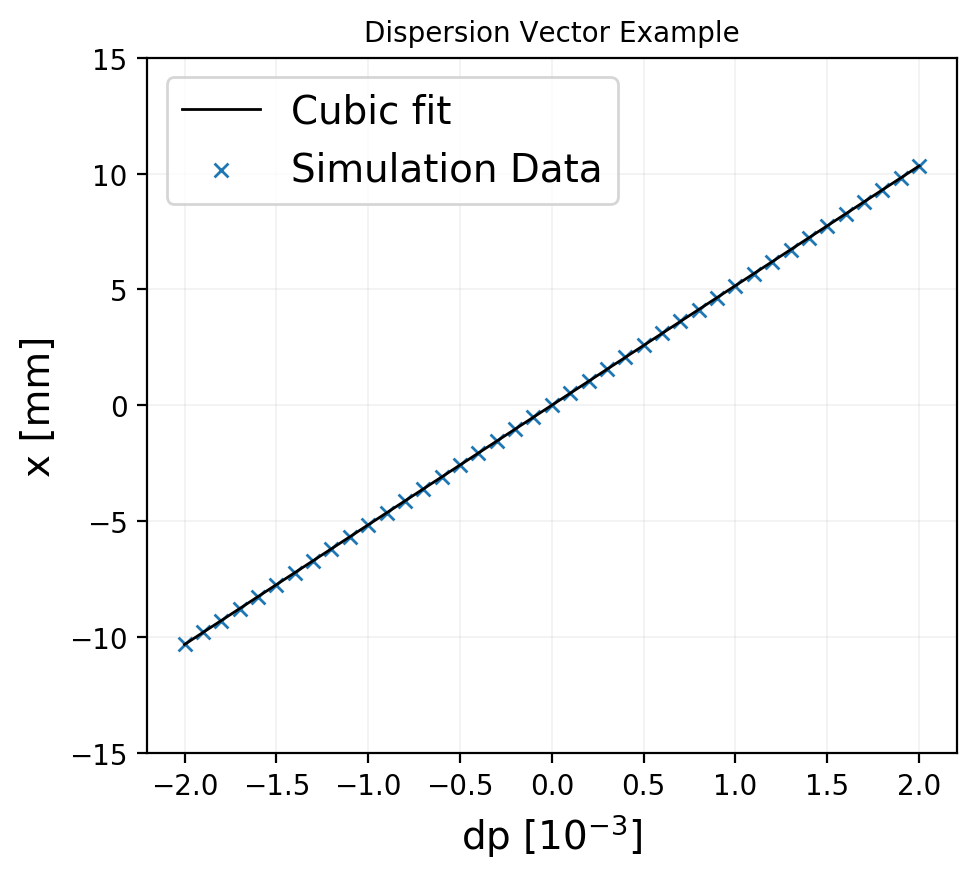

In [100]:
### Add fitting of the vector to find the linear dispersion:
n = 0;
fig1, ax1 = plt.subplots(1, tight_layout=True);

d = d1_H_07

D_test = []  
D2_test = [] 
D3_test = [] 
Intercept_test = []   

parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;

ax1.set_title('Dispersion Vector Example');
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(linewidth=0.1);
ax1.set_ylim(-15, 15);


x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0])
ax1.scatter(x, y, marker='x', label='Simulation Data');

min_dp = np.min(x)
max_dp = np.max(x)
DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

popt_test, pcov_test = curve_fit(cubic, x, y);
                                 
D_test.append(popt_test[1]);
D2_test.append(popt_test[0]);
D3_test.append(popt_test[3]);
Intercept_test.append(popt_test[2]);
ax1.plot(DELTAP_range, cubic(DELTAP_range,popt_test[0],popt_test[1],popt_test[2],popt_test[3]),'-k', label='Cubic fit');

ax1.legend();

savename = test_save_folder +'/Fitted_Dispersion_Vector_Example.png'
plt.savefig(savename);

print 'Fitted linear dispersion = ',round_sig(D_test[0]), ' m'


### Create a master dictionary to hold:
- All fitted dispersionn values D_1, D_2, D_3, and intercept D_i
- For all turns
- For all simulated cases in format 0_H_07

d[case][D_1] = [list of linear dispersion for all turns]
d[case][BETX] = initial horizontal beta function

In [93]:
master_dict = dict()

In [95]:
dispersion_vector_save_folder = 'Dispersion_Vectors'
make_directory(dispersion_vector_save_folder)

Creation of the directory Dispersion_Vectors failed


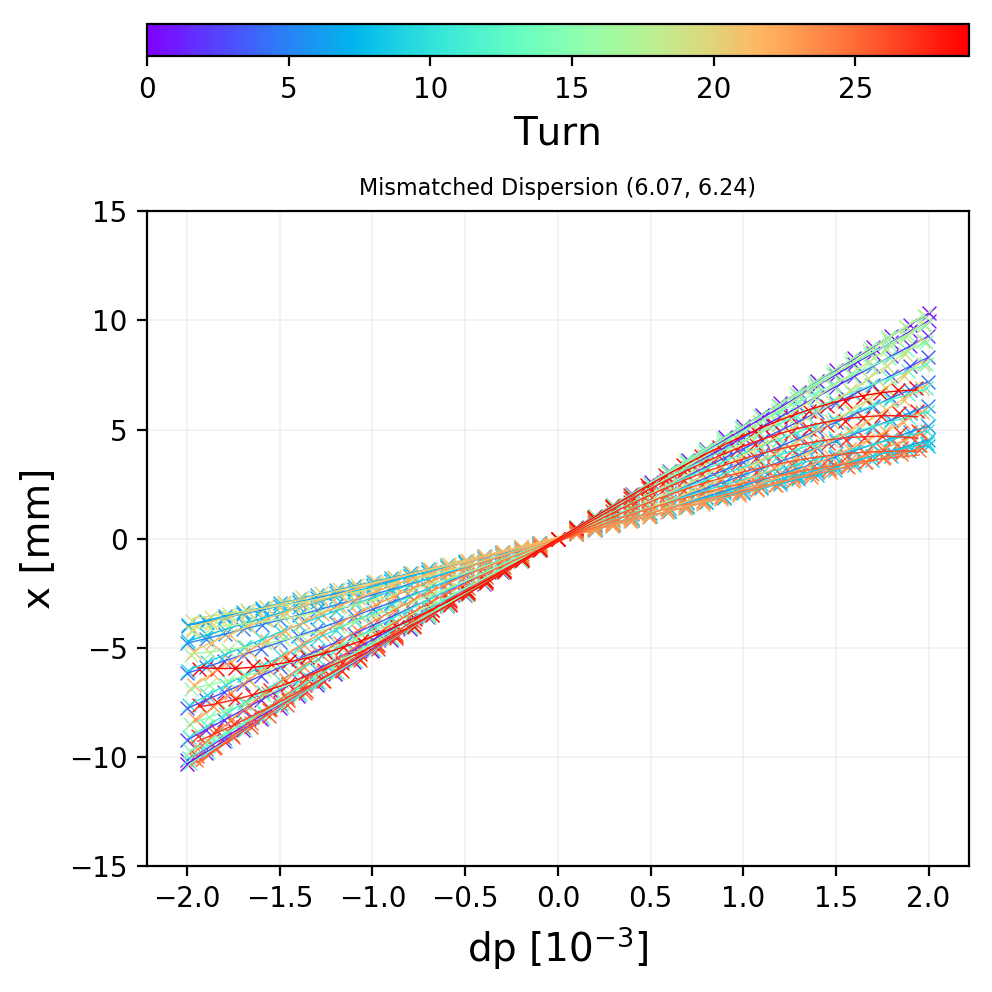

In [96]:
d_case = d1_H_07
case_label = '1_H_07'

# arrays to hold fitted values
D_1 = []
D_2 = []
D_3 = []
D_i = []

# Plot parameters
plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['lines.linewidth'] = 0.5

# Create figure
#fig1, ax1 = plt.subplots(1);
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]) 
ax2 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

#fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

# Select parameters and labels etc
parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(linewidth=0.1);
ax1.set_ylim(-15, 15);

transverse_plane = case_label.split('_')[1]
dispersion_mismatch = int(case_label.split('_')[0][-1])
tune = int(case_label.split('_')[2])
if transverse_plane is 'H':
    full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)')
else:
    full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')')
    
if dispersion_mismatch:
    d_mismatch_label = 'Mismatched Dispersion '
else:
    d_mismatch_label = 'Lattice Dispersion '

full_title = d_mismatch_label+full_tune

ax1.set_title(full_title)

# Iterate over turn
maxi = 30
turns = range(0,maxi)

colors = cm.rainbow(np.linspace(0, 1, len(turns)))
c_it = 0

cmap = mpl.cm.rainbow
norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Turn')

for n in turns:  
   
    x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
    y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0])
    ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

    min_dp = np.min(x)
    max_dp = np.max(x)
    DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

    popt, pcov = curve_fit(cubic, x, y);

    D_1.append(popt[1]);
    D_2.append(popt[0]);
    D_3.append(popt[3]);
    D_i.append(popt[2]);
    ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
    c_it = c_it + 1;
    
savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png'
plt.savefig(savename);

master_dict[case_label] = dict()
master_dict[case_label]['D_1'] = D_1
master_dict[case_label]['D_2'] = D_2
master_dict[case_label]['D_3'] = D_3
master_dict[case_label]['D_i'] = D_i

In [75]:
master_dict['1_H_07']['D_1'][0]

5.163067143737946

In [ ]:
len(D_1H_1)

In [ ]:
D_1H_1

In [ ]:
plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['axes.titlesize'] = 8

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1

parameter1 = 'dE'
parameter2 = 'x'
multi1 = 1E3
multi2 = 1E3

bet_x = 0.91

SEM_D_OP = []  
SEM_D2_OP = []  
SEM_D_LAT = []  
SEM_D2_LAT = []  
SEM_D_REM = []  
SEM_D2_REM = []  
i = 0

SIM_D3_OP = []
SIM_Intercept_OP = []
SIM_D3_LAT = []
SIM_Intercept_LAT = []
SIM_D3_REM = []
SIM_Intercept_REM = []

for key, value in sorted(dd_op.iteritems()):
    
    fig1, ax1 = plt.subplots(1)
    tit = main_label + ' ' + sc + ' ' + parameter1 + ' ' + parameter2 + ' turn ' + str(key)    
    ax1.set_title(tit);
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    
    # Fit dispersion vector as cubic
    popt_Lat, pcov_Lat = curve_fit(cubic,((dd_lat[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_lat[key]['particles'][parameter2][0][0][0]-closed_orbit_x_lat)*multi2)
    SEM_D_LAT.append(popt_Lat[1]*1E-3)
    SEM_D2_LAT.append(popt_Lat[0]*1E-3) 
    SIM_D3_LAT.append(popt_Lat[3])
    SIM_Intercept_LAT.append(popt_Lat[2])
    
    popt_op, pcov_op = curve_fit(cubic,((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_op[key]['particles'][parameter2][0][0][0]-closed_orbit_x_op)*multi2)
    SEM_D_OP.append(popt_op[1]*1E-3)
    SEM_D2_OP.append(popt_op[0]*1E-3)   
    SIM_D3_OP.append(popt_op[3])
    SIM_Intercept_OP.append(popt_op[2])

    popt_ReM, pcov_Lat = curve_fit(cubic,((dd_ReM[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_ReM[key]['particles'][parameter2][0][0][0]-closed_orbit_x_ReM)*multi2)
    SEM_D_REM.append(popt_ReM[1]*1E-3)
    SEM_D2_REM.append(popt_ReM[0]*1E-3)  
    SIM_D3_REM.append(popt_ReM[3])
    SIM_Intercept_REM.append(popt_ReM[2])  

    min_dp = np.min(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2))
    max_dp = np.max(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2))
    DELTAP_range = np.arange(min_dp, max_dp, 0.1e-4)        
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_Lat[0],popt_Lat[1],popt_Lat[2],popt_Lat[3]),'-k')
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_op[0],popt_op[1],popt_op[2],popt_op[3]),'-b')
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_ReM[0],popt_ReM[1],popt_ReM[2],popt_ReM[3]),'-r')

    # Plot particles
    s = np.ones(len(dd_op[key]['particles'][parameter1][0][0][0]))*4
    ax1.scatter(((dd_lat[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_lat[key]['particles'][parameter2][0][0][0]-closed_orbit_x_lat)*multi2, color='k', marker='x', s=s);
    ax1.scatter(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_op[key]['particles'][parameter2][0][0][0]-closed_orbit_x_op)*multi2, color='b', marker='x', s=s);
    ax1.scatter(((dd_ReM[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_ReM[key]['particles'][parameter2][0][0][0]-closed_orbit_x_ReM)*multi2, color='r', marker='x', s=s);

    ax1.grid(linewidth=0.1)
    ax1.set_ylim(-10, 10)
    
    custom_lines = [Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='r', lw=1)]

    ax1.legend(custom_lines, ['MD211@WS', 'PS_Transfer@SEM', 'PS_Transfer@SEM'], fontsize='x-small', loc=1)
 
    plot_savename = 'Plots/dE_x/Turn_' + str(key) + '.png'
    plt.savefig(plot_savename, dpi = 600)

In [ ]:
main_label = 'MD211_Test'
sc = 'noSC'
legend_label = 'Turn'

In [ ]:
# access all particle x co-ordinates like this
dd_op[0]['particles']['dE'][0][0][0]

# From PTC Twiss

In [ ]:
# Plot initial distns to check

Beta = 0.915839281848
E = 2336654575.29 * 1E-9 

# Operational (PS Transfer @ SEM)
DX0_op = 2.633
DPX0_op = -0.1104

# ReMatched (PS Transfer @ WS)
DX0_ReM = 4.781
DPX0_ReM = -0.000203524859163

#Lattice (MD211 @ WS)
DX0_lat = 4.781
DPX0_lat = -0.001107

DELTAP = np.arange(-2.,2.1,0.1)*1e-3

DE = (DELTAP) * Beta * Beta * E

X0_lat = DELTAP*DX0_lat + closed_orbit_x_lat
PX0_lat = DELTAP*DPX0_lat + closed_orbit_xp_lat

X0_op = DELTAP*DX0_op + closed_orbit_x_op
PX0_op = DELTAP*DPX0_op + closed_orbit_xp_op

X0_ReM = DELTAP*DX0_ReM + closed_orbit_x_ReM
PX0_ReM = DELTAP*DPX0_ReM + closed_orbit_xp_ReM

Z0 = np.zeros(np.shape(X0_lat))
Y0 = np.zeros(np.shape(X0_lat))
PY0 = np.zeros(np.shape(X0_lat))

## Plot initial distns to check

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

fig1, ax1 = plt.subplots(3, 3)

ax1[0, 0].set_title('Dispersion Vector Initial Distribution', fontsize=8);
ax1[0, 1].set_title('Closed Orbit Offsets Removed', fontsize=8);

ax1[0, 0].scatter((dd_op[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, dd_op[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[0, 0].scatter((X0_op-closed_orbit_x_lat)*1E3, Y0*1E3, marker='+', color='r');
ax1[0, 0].grid(linewidth=0.1);
ax1[0, 0].set_xlabel('x [mm]');
ax1[0, 0].set_ylabel('y [mm]');

ax1[0, 1].scatter(dd_op[0]['particles']['dE'][0][0][0], dd_op[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 1].scatter(DE, Z0, marker='+', color='r');
ax1[0, 1].grid(linewidth=0.1);
ax1[0, 1].set_ylabel('z [m]');
ax1[0, 1].set_xlabel('dE [GeV]');
ax1[0, 1].set_xlim(-1E-2, 1E-2);

ax1[0, 2].scatter( ((dd_op[0]['particles']['dE'][0][0][0])/E/Beta**2) , dd_op[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 2].scatter(DELTAP, Z0, marker='+', color='r');
ax1[0, 2].grid(linewidth=0.1);
ax1[0, 2].set_ylabel('z [m]');
ax1[0, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[0, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[1, 0].scatter((dd_op[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, (dd_op[0]['particles']['xp'][0][0][0]-closed_orbit_xp_lat)*1E3, marker='x');
ax1[1, 0].scatter((X0_op-closed_orbit_x_lat)*1E3, (PX0_op-closed_orbit_xp_lat)*1E3, marker='+', color='r');
ax1[1, 0].grid(linewidth=0.1);
ax1[1, 0].set_xlabel('x [mm]');
ax1[1, 0].set_ylabel(r'x$^{\prime}$ [mrad]');

ax1[1, 1].scatter(dd_op[0]['particles']['dE'][0][0][0], (dd_op[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, marker='x');
ax1[1, 1].scatter(DE, (X0_op-closed_orbit_x_lat)*1E3, marker='+', color='r');
ax1[1, 1].grid(linewidth=0.1);
ax1[1, 1].set_xlabel('dE [GeV]');
ax1[1, 1].set_ylabel('x [mm]');
ax1[1, 1].set_xlim(-1E-2, 1E-2);

ax1[1, 2].scatter(((dd_op[0]['particles']['dE'][0][0][0])/E/Beta**2), (dd_op[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, marker='x');
ax1[1, 2].scatter(DELTAP, (X0_op-closed_orbit_x_lat)*1E3, marker='+', color='r');
ax1[1, 2].grid(linewidth=0.1);
ax1[1, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[1, 2].set_ylabel('x [mm]');
ax1[1, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[2, 0].scatter(dd_op[0]['particles']['y'][0][0][0]*1E3, dd_op[0]['particles']['yp'][0][0][0]*1E3, marker='x');
ax1[2, 0].scatter(Y0*1E3, PY0*1E3, marker='+', color='r');
ax1[2, 0].grid(linewidth=0.1);
ax1[2, 0].set_xlabel('y [mm]');
ax1[2, 0].set_ylabel(r'y$^{\prime}$ [mrad]');

ax1[2, 1].scatter(dd_op[0]['particles']['dE'][0][0][0], dd_op[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 1].scatter(DE, Y0*1E3, marker='+', color='r');
ax1[2, 1].grid(linewidth=0.1);
ax1[2, 1].set_xlabel('dE [GeV]');
ax1[2, 1].set_ylabel('y [mm]');
ax1[2, 1].set_xlim(-1E-2, 1E-2);

ax1[2, 2].scatter(((dd_op[0]['particles']['dE'][0][0][0])/E/Beta**2)*1E3, dd_op[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 2].scatter(DELTAP*1E3, Y0*1E3, marker='+', color='r');
ax1[2, 2].grid(linewidth=0.1);
ax1[2, 2].set_xlabel(r'$\frac{dp}{p}$ [10$^{-3}$]');
ax1[2, 2].set_ylabel('y [mm]');
#ax1[2, 2].set_xlim(-2.5E-3, 2.5E-3);

fig1.tight_layout();

savename = 'Plots/Dispersion_Vector_Initial_Distribution_Op.png'
fig1.savefig(savename, dpi = 100)
#plt.close()

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1

fig1, ax1 = plt.subplots(3, 3)

ax1[0, 0].set_title('Dispersion Vector Initial Distribution', fontsize=8);
ax1[0, 1].set_title('Closed Orbit Offsets Removed', fontsize=8);

ax1[0, 0].scatter((dd_lat[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, dd_lat[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[0, 0].scatter((X0_lat-closed_orbit_x_lat)*1E3, Y0*1E3, marker='+', color='r');
ax1[0, 0].grid(linewidth=0.1);
ax1[0, 0].set_xlabel('x [mm]');
ax1[0, 0].set_ylabel('y [mm]');

ax1[0, 1].scatter(dd_lat[0]['particles']['dE'][0][0][0], dd_lat[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 1].scatter(DE, Z0, marker='+', color='r');
ax1[0, 1].grid(linewidth=0.1);
ax1[0, 1].set_ylabel('z [m]');
ax1[0, 1].set_xlabel('dE [GeV]');
ax1[0, 1].set_xlim(-1E-2, 1E-2);

ax1[0, 2].scatter( ((dd_lat[0]['particles']['dE'][0][0][0])/E/Beta**2) , dd_lat[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 2].scatter(DELTAP, Z0, marker='+', color='r');
ax1[0, 2].grid(linewidth=0.1);
ax1[0, 2].set_ylabel('z [m]');
ax1[0, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[0, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[1, 0].scatter((dd_lat[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, (dd_lat[0]['particles']['xp'][0][0][0]-closed_orbit_xp_lat)*1E3, marker='x');
ax1[1, 0].scatter((X0_lat-closed_orbit_x_lat)*1E3, (PX0_lat-closed_orbit_xp_lat)*1E3, marker='+', color='r');
ax1[1, 0].grid(linewidth=0.1);
ax1[1, 0].set_xlabel('x [mm]');
ax1[1, 0].set_ylabel(r'x$^{\prime}$ [mrad]');

ax1[1, 1].scatter(dd_lat[0]['particles']['dE'][0][0][0], (dd_lat[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, marker='x');
ax1[1, 1].scatter(DE, (X0_lat-closed_orbit_x_lat)*1E3, marker='+', color='r');
ax1[1, 1].grid(linewidth=0.1);
ax1[1, 1].set_xlabel('dE [GeV]');
ax1[1, 1].set_ylabel('x [mm]');
ax1[1, 1].set_xlim(-1E-2, 1E-2);

ax1[1, 2].scatter(((dd_lat[0]['particles']['dE'][0][0][0])/E/Beta**2), (dd_lat[0]['particles']['x'][0][0][0]-closed_orbit_x_lat)*1E3, marker='x');
ax1[1, 2].scatter(DELTAP, (X0_lat-closed_orbit_x_lat)*1E3, marker='+', color='r');
ax1[1, 2].grid(linewidth=0.1);
ax1[1, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[1, 2].set_ylabel('x [mm]');
ax1[1, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[2, 0].scatter(dd_lat[0]['particles']['y'][0][0][0]*1E3, dd_lat[0]['particles']['yp'][0][0][0]*1E3, marker='x');
ax1[2, 0].scatter(Y0*1E3, PY0*1E3, marker='+', color='r');
ax1[2, 0].grid(linewidth=0.1);
ax1[2, 0].set_xlabel('y [mm]');
ax1[2, 0].set_ylabel(r'y$^{\prime}$ [mrad]');

ax1[2, 1].scatter(dd_lat[0]['particles']['dE'][0][0][0], dd_lat[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 1].scatter(DE, Y0*1E3, marker='+', color='r');
ax1[2, 1].grid(linewidth=0.1);
ax1[2, 1].set_xlabel('dE [GeV]');
ax1[2, 1].set_ylabel('y [mm]');
ax1[2, 1].set_xlim(-1E-2, 1E-2);

ax1[2, 2].scatter(((dd_lat[0]['particles']['dE'][0][0][0])/E/Beta**2)*1E3, dd_lat[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 2].scatter(DELTAP*1E3, Y0*1E3, marker='+', color='r');
ax1[2, 2].grid(linewidth=0.1);
ax1[2, 2].set_xlabel(r'$\frac{dp}{p}$ [10$^{-3}$]');
ax1[2, 2].set_ylabel('y [mm]');
#ax1[2, 2].set_xlim(-2.5E-3, 2.5E-3);

fig1.tight_layout();

savename = 'Plots/Dispersion_Vector_Initial_Distribution_Lat.png'
fig1.savefig(savename, dpi = 100)
#plt.close()

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1

fig1, ax1 = plt.subplots(3, 3)

ax1[0, 0].set_title('Dispersion Vector Initial Distribution', fontsize=8);
ax1[0, 1].set_title('Closed Orbit Offsets Removed', fontsize=8);

ax1[0, 0].scatter((dd_ReM[0]['particles']['x'][0][0][0]-closed_orbit_x_ReM)*1E3, dd_ReM[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[0, 0].scatter((X0_ReM-closed_orbit_x_ReM)*1E3, Y0*1E3, marker='+', color='r');
ax1[0, 0].grid(linewidth=0.1);
ax1[0, 0].set_xlabel('x [mm]');
ax1[0, 0].set_ylabel('y [mm]');

ax1[0, 1].scatter(dd_ReM[0]['particles']['dE'][0][0][0], dd_ReM[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 1].scatter(DE, Z0, marker='+', color='r');
ax1[0, 1].grid(linewidth=0.1);
ax1[0, 1].set_ylabel('z [m]');
ax1[0, 1].set_xlabel('dE [GeV]');
ax1[0, 1].set_xlim(-1E-2, 1E-2);

ax1[0, 2].scatter( ((dd_ReM[0]['particles']['dE'][0][0][0])/E/Beta**2) , dd_ReM[0]['particles']['z'][0][0][0], marker='x');
ax1[0, 2].scatter(DELTAP, Z0, marker='+', color='r');
ax1[0, 2].grid(linewidth=0.1);
ax1[0, 2].set_ylabel('z [m]');
ax1[0, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[0, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[1, 0].scatter((dd_ReM[0]['particles']['x'][0][0][0]-closed_orbit_x_ReM)*1E3, (dd_ReM[0]['particles']['xp'][0][0][0]-closed_orbit_xp_ReM)*1E3, marker='x');
ax1[1, 0].scatter((X0_ReM-closed_orbit_x_ReM)*1E3, (PX0_ReM-closed_orbit_xp_ReM)*1E3, marker='+', color='r');
ax1[1, 0].grid(linewidth=0.1);
ax1[1, 0].set_xlabel('x [mm]');
ax1[1, 0].set_ylabel(r'x$^{\prime}$ [mrad]');

ax1[1, 1].scatter(dd_ReM[0]['particles']['dE'][0][0][0], (dd_ReM[0]['particles']['x'][0][0][0]-closed_orbit_x_ReM)*1E3, marker='x');
ax1[1, 1].scatter(DE, (X0_ReM-closed_orbit_x_ReM)*1E3, marker='+', color='r');
ax1[1, 1].grid(linewidth=0.1);
ax1[1, 1].set_xlabel('dE [GeV]');
ax1[1, 1].set_ylabel('x [mm]');
ax1[1, 1].set_xlim(-1E-2, 1E-2);

ax1[1, 2].scatter(((dd_ReM[0]['particles']['dE'][0][0][0])/E/Beta**2), (dd_ReM[0]['particles']['x'][0][0][0]-closed_orbit_x_ReM)*1E3, marker='x');
ax1[1, 2].scatter(DELTAP, (X0_ReM-closed_orbit_x_ReM)*1E3, marker='+', color='r');
ax1[1, 2].grid(linewidth=0.1);
ax1[1, 2].set_xlabel(r'$\frac{dp}{p}$ [-]');
ax1[1, 2].set_ylabel('x [mm]');
ax1[1, 2].set_xlim(-2.5E-3, 2.5E-3);

ax1[2, 0].scatter(dd_ReM[0]['particles']['y'][0][0][0]*1E3, dd_ReM[0]['particles']['yp'][0][0][0]*1E3, marker='x');
ax1[2, 0].scatter(Y0*1E3, PY0*1E3, marker='+', color='r');
ax1[2, 0].grid(linewidth=0.1);
ax1[2, 0].set_xlabel('y [mm]');
ax1[2, 0].set_ylabel(r'y$^{\prime}$ [mrad]');

ax1[2, 1].scatter(dd_ReM[0]['particles']['dE'][0][0][0], dd_ReM[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 1].scatter(DE, Y0*1E3, marker='+', color='r');
ax1[2, 1].grid(linewidth=0.1);
ax1[2, 1].set_xlabel('dE [GeV]');
ax1[2, 1].set_ylabel('y [mm]');
ax1[2, 1].set_xlim(-1E-2, 1E-2);

ax1[2, 2].scatter(((dd_ReM[0]['particles']['dE'][0][0][0])/E/Beta**2)*1E3, dd_ReM[0]['particles']['y'][0][0][0]*1E3, marker='x');
ax1[2, 2].scatter(DELTAP*1E3, Y0*1E3, marker='+', color='r');
ax1[2, 2].grid(linewidth=0.1);
ax1[2, 2].set_xlabel(r'$\frac{dp}{p}$ [10$^{-3}$]');
ax1[2, 2].set_ylabel('y [mm]');
#ax1[2, 2].set_xlim(-2.5E-3, 2.5E-3);

fig1.tight_layout();

savename = 'Plots/Dispersion_Vector_Initial_Distribution_ReM.png'
fig1.savefig(savename, dpi = 100)
#plt.close()

## Plot x - xp phase space

In [ ]:
plt.rcParams['figure.figsize'] = [2.0, 2.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.titlesize'] = 8

parameter1 = 'x'
parameter2 = 'xp'
multi1 = 1
multi2 = 1E3

for key, value in sorted(dd_op.iteritems()):
    
    fig1, ax1 = plt.subplots(1)
    tit = main_label + ' ' + sc + ' ' + parameter1 + ' ' + parameter2 + ' turn ' + str(key)    
    ax1.set_title(tit);
    ax1.set_xlabel('x [mm]');
    ax1.set_ylabel(r'x$^{\prime}$ [mrad]');

    s = np.ones(len(dd_op[key]['particles'][parameter1][0][0][0]))
    ax1.scatter((dd_lat[key]['particles'][parameter1][0][0][0]-closed_orbit_x_lat)*multi1, (dd_lat[key]['particles'][parameter2][0][0][0] - closed_orbit_xp_lat)*multi2, color='k', marker='x', s=s);
    ax1.scatter((dd_op[key]['particles'][parameter1][0][0][0]-closed_orbit_x_op)*multi1, (dd_op[key]['particles'][parameter2][0][0][0] - closed_orbit_xp_op)*multi2, color='b', marker='x', s=s);
    ax1.scatter((dd_ReM[key]['particles'][parameter1][0][0][0]-closed_orbit_x_ReM)*multi1, (dd_ReM[key]['particles'][parameter2][0][0][0] - closed_orbit_xp_ReM)*multi2, color='r', marker='x', s=s);
    

    #ax1.legend(fontsize='x-small', loc=4, title=legend_label)
    ax1.grid(linewidth=0.1)
    #ax1.set_xlim(-2E-3, 2E-3)
    #ax1.set_xlim(-10, 10)
    custom_lines = [Line2D([0], [0], color='k', lw=1),
                    Line2D([0], [0], color='b', lw=1),
                    Line2D([0], [0], color='r', lw=1)]

    #ax1.legend(custom_lines, ['Lattice', 'Operational'], fontsize='x-small', loc=1)
    ax1.legend(custom_lines, ['MD211@WS', 'PS_Transfer@SEM', 'PS_Transfer@SEM'], fontsize='x-small', loc=1)
    #savename = 'Plots/x_xp/' + parameter1 + ' ' +  parameter2 + 'turn_' + str(int(key)) + '_V_bw.png'
    
    #bw_gifnames_x_xp.append(savename)
    
    #fig1.savefig(savename, dpi = 100)
    #plt.close()

## Plot x - dE phase space

In [ ]:
plt.rcParams['figure.figsize'] = [2.0, 2.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.titlesize'] = 8

parameter1 = 'dE'
parameter2 = 'x'
multi1 = 1E3
multi2 = 1E3

for key, value in sorted(dd_op.iteritems()):
    
    fig1, ax1 = plt.subplots(1)
    tit = main_label + ' ' + sc + ' ' + parameter1 + ' ' + parameter2 + ' turn ' + str(key)    
    ax1.set_title(tit);
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');

    s = np.ones(len(dd_op[key]['particles'][parameter1][0][0][0]))
    ax1.scatter((dd_lat[key]['particles'][parameter1][0][0][0])*multi1, (dd_lat[key]['particles'][parameter2][0][0][0] - closed_orbit_x_lat)*multi2, color='k', marker='x', s=s);
    ax1.scatter((dd_op[key]['particles'][parameter1][0][0][0])*multi1, (dd_op[key]['particles'][parameter2][0][0][0] - closed_orbit_x_op)*multi2, color='b', marker='x', s=s);
    ax1.scatter((dd_ReM[key]['particles'][parameter1][0][0][0])*multi1, (dd_ReM[key]['particles'][parameter2][0][0][0] - closed_orbit_x_ReM)*multi2, color='r', marker='x', s=s);

    #ax1.legend(fontsize='x-small', loc=4, title=legend_label)
    ax1.grid(linewidth=0.1)
    #ax1.set_xlim(-2E-3, 2E-3)
    #ax1.set_xlim(-10, 10)
    custom_lines = [Line2D([0], [0], color='k', lw=1),
                    Line2D([0], [0], color='b', lw=1),
                    Line2D([0], [0], color='r', lw=1)]
    
    #ax1.legend(custom_lines, ['Lattice', 'Operational'], fontsize='x-small', loc=1)
    ax1.legend(custom_lines, ['MD211@WS', 'PS_Transfer@SEM', 'PS_Transfer@SEM'], fontsize='x-small', loc=1)
    #savename = 'Plots/x_xp/' + parameter1 + ' ' +  parameter2 + 'turn_' + str(int(key)) + '_V_bw.png'
    
    #bw_gifnames_x_xp.append(savename)
    
    #fig1.savefig(savename, dpi = 100)
    #plt.close()

## Add fitting to separate linear and non-linear dispersion

In [ ]:
plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['axes.titlesize'] = 8

plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['lines.linewidth'] = 1

parameter1 = 'dE'
parameter2 = 'x'
multi1 = 1E3
multi2 = 1E3

bet_x = 0.91

SEM_D_OP = []  
SEM_D2_OP = []  
SEM_D_LAT = []  
SEM_D2_LAT = []  
SEM_D_REM = []  
SEM_D2_REM = []  
i = 0

SIM_D3_OP = []
SIM_Intercept_OP = []
SIM_D3_LAT = []
SIM_Intercept_LAT = []
SIM_D3_REM = []
SIM_Intercept_REM = []

for key, value in sorted(dd_op.iteritems()):
    
    fig1, ax1 = plt.subplots(1)
    tit = main_label + ' ' + sc + ' ' + parameter1 + ' ' + parameter2 + ' turn ' + str(key)    
    ax1.set_title(tit);
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    
    # Fit dispersion vector as cubic
    popt_Lat, pcov_Lat = curve_fit(cubic,((dd_lat[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_lat[key]['particles'][parameter2][0][0][0]-closed_orbit_x_lat)*multi2)
    SEM_D_LAT.append(popt_Lat[1]*1E-3)
    SEM_D2_LAT.append(popt_Lat[0]*1E-3) 
    SIM_D3_LAT.append(popt_Lat[3])
    SIM_Intercept_LAT.append(popt_Lat[2])
    
    popt_op, pcov_op = curve_fit(cubic,((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_op[key]['particles'][parameter2][0][0][0]-closed_orbit_x_op)*multi2)
    SEM_D_OP.append(popt_op[1]*1E-3)
    SEM_D2_OP.append(popt_op[0]*1E-3)   
    SIM_D3_OP.append(popt_op[3])
    SIM_Intercept_OP.append(popt_op[2])

    popt_ReM, pcov_Lat = curve_fit(cubic,((dd_ReM[key]['particles'][parameter1][0][0][0])/E/Beta**2), (dd_ReM[key]['particles'][parameter2][0][0][0]-closed_orbit_x_ReM)*multi2)
    SEM_D_REM.append(popt_ReM[1]*1E-3)
    SEM_D2_REM.append(popt_ReM[0]*1E-3)  
    SIM_D3_REM.append(popt_ReM[3])
    SIM_Intercept_REM.append(popt_ReM[2])  

    min_dp = np.min(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2))
    max_dp = np.max(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2))
    DELTAP_range = np.arange(min_dp, max_dp, 0.1e-4)        
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_Lat[0],popt_Lat[1],popt_Lat[2],popt_Lat[3]),'-k')
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_op[0],popt_op[1],popt_op[2],popt_op[3]),'-b')
    ax1.plot(DELTAP_range*multi1, cubic(DELTAP_range,popt_ReM[0],popt_ReM[1],popt_ReM[2],popt_ReM[3]),'-r')

    # Plot particles
    s = np.ones(len(dd_op[key]['particles'][parameter1][0][0][0]))*4
    ax1.scatter(((dd_lat[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_lat[key]['particles'][parameter2][0][0][0]-closed_orbit_x_lat)*multi2, color='k', marker='x', s=s);
    ax1.scatter(((dd_op[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_op[key]['particles'][parameter2][0][0][0]-closed_orbit_x_op)*multi2, color='b', marker='x', s=s);
    ax1.scatter(((dd_ReM[key]['particles'][parameter1][0][0][0])/E/Beta**2)*multi1, (dd_ReM[key]['particles'][parameter2][0][0][0]-closed_orbit_x_ReM)*multi2, color='r', marker='x', s=s);

    ax1.grid(linewidth=0.1)
    ax1.set_ylim(-10, 10)
    
    custom_lines = [Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='r', lw=1)]

    ax1.legend(custom_lines, ['MD211@WS', 'PS_Transfer@SEM', 'PS_Transfer@SEM'], fontsize='x-small', loc=1)
 
    plot_savename = 'Plots/dE_x/Turn_' + str(key) + '.png'
    plt.savefig(plot_savename, dpi = 600)

In [ ]:
print SEM_D_OP[0]
print SEM_D2_OP[0]
print SEM_D_LAT[0]
print SEM_D2_LAT[0]
print SEM_D_REM[0]
print SEM_D2_REM[0]

In [ ]:
print '\n\tINITIAL VALUE SUMMARY'
print '\nD_0 OP = ', SEM_D_OP[0]
print 'D_0 LAT = ',  SEM_D_LAT[0]
print 'D_0 ReM = ',  SEM_D_REM[0]

print '\nD_1 OP = ', SEM_D2_OP[0]
print 'D_1 LAT = ', SEM_D2_LAT[0]
print 'D_1 ReM = ', SEM_D2_REM[0]

print '\nD_2 OP = ', SIM_D3_OP[0]
print 'D_2 LAT = ', SIM_D3_LAT[0]
print 'D_2 ReM = ', SIM_D3_REM[0]

print '\nC OP = ', SIM_Intercept_OP[0]
print 'C LAT = ', SIM_Intercept_LAT[0]
print 'C ReM = ', SIM_Intercept_REM[0]

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

trns = 31
turns = np.arange(0, trns, 1)

x = np.array(turns)

y = np.array(SEM_D_OP)
ax2.plot(x, y,'r',label = r'$D_0$')

y = np.array(SEM_D2_OP)/100
ax1.plot(x, y,'b',label = r'$\frac{D_1}{10^2}$')

y = np.array(SIM_D3_OP)/1E7
ax1.plot(x, y,'g',label = r'$\frac{D_2}{10^7}$', ls=':')

y = np.array(SIM_Intercept_OP)
ax1.plot(x, y,'k',label = 'intercept c', ls='--')

ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(1, 4)

ax1.set_ylabel('Normalised Dispersion Component', color='k')
ax2.set_ylabel(r'Linear Dispersion $D_{x_0}$ [m]', color='r')
ax1.set_xlabel('Turn [-]')

ax1.legend(loc=2)
ax1.grid(ls=':', lw=0.5)

plt.tight_layout()
plt.savefig('Plots/Fitted_Dispersion_Components_OP.png', dpi = 600)

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

trns = 31
turns = np.arange(0, trns, 1)

x = np.array(turns)

y = np.array(SEM_D_REM)
ax2.plot(x, y,'r',label = r'$D_0$')

y = np.array(SEM_D2_REM)/100
ax1.plot(x, y,'b',label = r'$\frac{D_1}{10^2}$')

y = np.array(SIM_D3_REM)/1E7
ax1.plot(x, y,'g',label = r'$\frac{D_2}{10^7}$', ls=':')

y = np.array(SIM_Intercept_REM)
ax1.plot(x, y,'k',label = 'intercept c', ls='--')

ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(1, 5)

ax1.set_ylabel('Normalised Dispersion Component', color='k')
ax2.set_ylabel(r'Linear Dispersion $D_{x_0}$ [m]', color='r')
ax1.set_xlabel('Turn [-]')

ax1.legend(loc=1)
ax1.grid(ls=':', lw=0.5)

plt.tight_layout()
plt.savefig('Plots/Fitted_Dispersion_Components_REM.png', dpi = 600)

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

trns = 31
turns = np.arange(0, trns, 1)

x = np.array(turns)

y = np.array(SEM_D_LAT)
ax2.plot(x, y,'r',label = r'$D_0$')

y = np.array(SEM_D2_LAT)/100
ax1.plot(x, y,'b',label = r'$\frac{D_1}{10^2}$')

y = np.array(SIM_D3_LAT)/1E7
ax1.plot(x, y,'g',label = r'$\frac{D_2}{10^7}$', ls=':')

y = np.array(SIM_Intercept_LAT)
ax1.plot(x, y,'k',label = 'intercept c', ls='--')

ax1.set_ylim(-1.5, 1.5)
ax2.set_ylim(1, 4)

ax1.set_ylabel('Normalised Dispersion Component', color='k')
ax2.set_ylabel(r'Linear Dispersion $D_{x_0}$ [m]', color='r')
ax1.set_xlabel('Turn [-]')

ax1.legend(loc=1)
ax1.grid(ls=':', lw=0.5)

plt.tight_layout()
plt.savefig('Plots/Fitted_Dispersion_Components_LAT.png', dpi = 600)

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 12

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

trns = 31
turns = np.arange(0, trns, 1)
turns_fine = np.arange(0, trns, 0.1)

x = np.array(turns)

y = np.array(SIM_Intercept_OP)
popt_Lat, pcov_Lat = curve_fit(harmonic_fn, x, y, method = 'trf', bounds =((-1,-np.inf,-np.inf,0.1499),(1,np.inf,np.inf,0.2499)))
lab_= r'PS_Transfer@SEM $f_{intercept} = $'+ str(round_sig(popt_Lat[3],4))
plt.plot(turns_fine, harmonic_fn(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'b',label = lab_)
plt.scatter(x, y, color='b',marker='x')

y = np.array(SIM_Intercept_REM)
popt_Lat, pcov_Lat = curve_fit(harmonic_fn, x, y, method = 'trf', bounds =((-1,-np.inf,-np.inf,0.1499),(1,np.inf,np.inf,0.2499)))
lab_= r'PS_Transfer@WS $f_{intercept} = $'+ str(round_sig(popt_Lat[3],4))
plt.plot(turns_fine, harmonic_fn(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'r',label = lab_)
plt.scatter(x, y, color='r',marker='x')

y = np.array(SIM_Intercept_LAT)
popt_Lat, pcov_Lat = curve_fit(harmonic_fn, x, y, method = 'trf', bounds =((-1,-np.inf,-np.inf,0.1499),(1,np.inf,np.inf,0.2499)))
lab_= r'MD211@WS $f_{intercept} = $'+ str(round_sig(popt_Lat[3],4))
plt.plot(turns_fine, harmonic_fn(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'k',label = lab_)
plt.scatter(x, y, color='k',marker='x')

plt.ylabel('Dispersion Vector Intercept')
plt.xlabel('Turn [-]')
ax1.legend(loc=4)
plt.grid(ls=':', lw=0.5)

plt.tight_layout()
plt.savefig('Plots/Fitted_Dispersion_Intercepts.png', dpi = 600)

In [ ]:
print len(SEM_D_OP)

In [ ]:
# Remove turn -1
#SEM_D_OP = SEM_D_OP[1:]
#SEM_D2_OP = SEM_D2_OP[1:]
#SEM_D_LAT = SEM_D_LAT[1:]
#SEM_D2_LAT = SEM_D2_LAT[1:]
#SEM_D_REM = SEM_D_REM[1:]
#SEM_D2_REM = SEM_D2_REM[1:]

## Plot dispersion beating

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = 31
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

turns_fine = np.arange(0, 31, 0.1)

y_Lat = (SEM_D_LAT-np.mean(SEM_D_LAT))
freq_Lat = pnf.naff(y_Lat, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Lat = 'Lattice freq=' + str(round_sig(freq_Lat))

y_Op = (SEM_D_OP-np.mean(SEM_D_OP))
freq_Op = pnf.naff(y_Op, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Op = 'Operational freq=' + str(round_sig(freq_Op))

y_ReM = (SEM_D_REM-np.mean(SEM_D_REM))
freq_ReM = pnf.naff(y_ReM, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]

popt_Lat, pcov_Lat = curve_fit(Md_fit, turns, SEM_D_LAT, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_LAT, marker = 'x', color = 'k')
plt.plot(turns_fine, Md_fit(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'k',label = 'MD211@WS')
plt.plot([turns[0], turns[-1]], [popt_Lat[0],popt_Lat[0]],'--k')

popt_op, pcov_op = curve_fit(Md_fit, turns, SEM_D_OP, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_OP, marker = 'x', color = 'b')
plt.plot(turns_fine, Md_fit(turns_fine, popt_op[0], popt_op[1], popt_op[2], popt_op[3]),'b',label = 'PS_Transfer@SEM')
plt.plot([turns[0], turns[-1]], [popt_op[0],popt_op[0]],'--b')

popt_ReM, pcov_ReM = curve_fit(Md_fit, turns, SEM_D_REM, method = 'trf', bounds =((2,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_REM, marker = 'x', color = 'r')
plt.plot(turns_fine, Md_fit(turns_fine, popt_ReM[0], popt_ReM[1], popt_ReM[2], popt_ReM[3]),'r',label = 'PS_Transfer@WS')
plt.plot([turns[0], turns[-1]], [popt_ReM[0],popt_ReM[0]],'--r')
print popt_ReM[0]
print popt_op[0]
print popt_Lat[0]

plt.xlabel('Turn [-]')
plt.ylabel(r'D$_{0,x}$ [m]')
#plt.title('PI.BSG52')
plt.xlim((-1, 30))
plt.ylim((1, 5))
plt.grid(ls=':', lw=0.5)
plt.legend(loc = 4, prop=dict(size=10))

ax1 = plt.gca()
#ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig('Plots/D0_NoRF_NoSC.png', dpi = 600)

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = 31
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

turns_fine = np.arange(0, 30, 0.1)

y_Lat = (SEM_D_LAT-np.mean(SEM_D_LAT))
freq_Lat = pnf.naff(y_Lat, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Lat = 'MD211@WS freq=' + str(round_sig(freq_Lat))

y_Op = (SEM_D_OP-np.mean(SEM_D_OP))
freq_Op = pnf.naff(y_Op, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Op = 'PS_Transfer@SEM freq=' + str(round_sig(freq_Op))

y_ReM = (SEM_D_REM-np.mean(SEM_D_REM))
freq_ReM = pnf.naff(y_ReM, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_ReM = 'PS_Transfer@WS freq=' + str(round_sig(freq_ReM,3))

popt_Lat, pcov_Lat = curve_fit(Md_fit, turns, SEM_D_LAT, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_LAT, marker = 'x', color = 'k')
plt.plot(turns_fine, Md_fit(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'k',label = lab_Lat)
plt.plot([turns[0], turns[-1]], [popt_Lat[0],popt_Lat[0]],'--k')

popt_op, pcov_op = curve_fit(Md_fit, turns, SEM_D_OP, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_OP, marker = 'x', color = 'b')
plt.plot(turns_fine, Md_fit(turns_fine, popt_op[0], popt_op[1], popt_op[2], popt_op[3]),'b',label = lab_Op)
plt.plot([turns[0], turns[-1]], [popt_op[0],popt_op[0]],'--b')

popt_ReM, pcov_ReM = curve_fit(Md_fit, turns, SEM_D_REM, method = 'trf', bounds =((2,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_REM, marker = 'x', color = 'r')
plt.plot(turns_fine, Md_fit(turns_fine, popt_ReM[0], popt_ReM[1], popt_ReM[2], popt_ReM[3]),'r',label = lab_ReM)
plt.plot([turns[0], turns[-1]], [popt_ReM[0],popt_ReM[0]],'--r')
print popt_ReM[0]
print popt_op[0]
print popt_Lat[0]

plt.xlabel('Turn [-]')
plt.ylabel(r'D$_{0,x}$ [m]')
#plt.title('PI.BSG52')
plt.xlim((-1, 30))
plt.ylim((1, 5))
plt.grid(ls=':', lw=0.5)
plt.legend(loc = 1, prop=dict(size=10))

ax1 = plt.gca()
#ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig('Plots/D0_NoRF_NoSC_NAFF.png', dpi = 600)

## Plot normalised dispersion beating

In [ ]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = 31
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

turns_fine = np.arange(0, 30, 0.1)

y_Lat = (SEM_D_LAT-np.mean(SEM_D_LAT))
freq_Lat = pnf.naff(y_Lat, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Lat = 'MD211@WS freq=' + str(round_sig(freq_Lat))

y_Op = (SEM_D_OP-np.mean(SEM_D_OP))
freq_Op = pnf.naff(y_Op, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_Op = 'PS_Transfer@SEM freq=' + str(round_sig(freq_Op))

y_ReM = (SEM_D_REM-np.mean(SEM_D_REM))
freq_ReM = pnf.naff(y_ReM, turns=29, nterms=1, skipTurns=0, getFullSpectrum=False, window=1)[0][1]
lab_ReM = 'PS_Transfer@WS freq=' + str(round_sig(freq_ReM,3))

popt_Lat, pcov_Lat = curve_fit(Md_fit, turns, SEM_D_LAT/np.sqrt(beta_x_lat), method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_LAT/np.sqrt(beta_x_lat), marker = 'x', color = 'k')
plt.plot(turns_fine, Md_fit(turns_fine, popt_Lat[0], popt_Lat[1], popt_Lat[2], popt_Lat[3]),'k',label = 'MD211 Lattice @ Wire-Scanner')
plt.plot([turns[0], turns[-1]], [popt_Lat[0],popt_Lat[0]],'--k')

popt_op, pcov_op = curve_fit(Md_fit, turns, SEM_D_OP/np.sqrt(beta_x_op), method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_OP/np.sqrt(beta_x_op), marker = 'x', color = 'b')
plt.plot(turns_fine, Md_fit(turns_fine, popt_op[0], popt_op[1], popt_op[2], popt_op[3]),'b',label = 'Mismatch Measurement Lattice @ SEM Grid')
plt.plot([turns[0], turns[-1]], [popt_op[0],popt_op[0]],'--b')

popt_ReM, pcov_ReM = curve_fit(Md_fit, turns, SEM_D_REM/np.sqrt(beta_x_ReM), method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.scatter(turns, SEM_D_REM/np.sqrt(beta_x_ReM), marker = 'x', color = 'r')
plt.plot(turns_fine, Md_fit(turns_fine, popt_ReM[0], popt_ReM[1], popt_ReM[2], popt_ReM[3]),'r',label = 'Mismatch Measurement Lattice @ Wire-Scanner')
plt.plot([turns[0], turns[-1]], [popt_ReM[0],popt_ReM[0]],'--r')
print popt_ReM[0]
print popt_op[0]
print popt_Lat[0]

print '\nInitial normalised dispersion MD211@WS', SEM_D_REM[0]/np.sqrt(beta_x_ReM)
print 'Initial normalised dispersion PS_Transfer@SEM: ',SEM_D_OP[0]/np.sqrt(beta_x_op), 'm'
print 'Initial normalised dispersion PS_Transfer@WS: ',SEM_D_LAT[0]/np.sqrt(beta_x_lat), 'm'

plt.xlabel('Turn [-]')
plt.ylabel(r'Normalised Horizontal Dispersion   $D_{0,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
#plt.title('PI.BSG52')
plt.xlim((-1, 30))
plt.ylim(0.2,1.4)
plt.grid(ls=':', lw=0.5)
plt.legend(loc = 1, prop=dict(size=10))
ax1.set_title(r'Applying Dispersion Mismatch $M_D$ = 0.35')

ax1 = plt.gca()
#ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig('Plots/Applying_Dispersion_Mismatch.png', dpi = 600)

## Plot normalised dispersion offset

In [ ]:
# Plot together the measured and simulated turn-by-turn Normalised dispersion:.
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = 31
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

plt.figure()

popt_LAT_H_sim, pcov_LAT_H_sim = curve_fit(Md_fit, turns, SEM_D_LAT, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.plot(turns, ((SEM_D_LAT)-popt_LAT_H_sim[0])/np.sqrt(beta_x_lat),'xk')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_LAT_H_sim[0],popt_LAT_H_sim[1],popt_LAT_H_sim[2],popt_LAT_H_sim[3])-popt_LAT_H_sim[0])/np.sqrt(beta_x_lat),'k',label = 'MD211 Lattice @ Wire-Scanner')

popt_OP_H_sim, pcov_OP_H_sim = curve_fit(Md_fit, turns, SEM_D_OP, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.plot(turns, ((SEM_D_OP)-popt_OP_H_sim[0])/np.sqrt(beta_x_op),'xb')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_OP_H_sim[0],popt_OP_H_sim[1],popt_OP_H_sim[2],popt_OP_H_sim[3])-popt_OP_H_sim[0])/np.sqrt(beta_x_op),'b',label = 'Mismatch Measurement Lattice @ SEM Grid')

popt_REM_H_sim, pcov_REM_H_sim = curve_fit(Md_fit, turns, SEM_D_REM, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
print popt_REM_H_sim[0]
plt.plot(turns, ((SEM_D_REM)-popt_REM_H_sim[0])/np.sqrt(beta_x_ReM),'xr')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_REM_H_sim[0],popt_REM_H_sim[1],popt_REM_H_sim[2],popt_REM_H_sim[3])-popt_REM_H_sim[0])/np.sqrt(beta_x_ReM),'r',label = 'Mismatch Measurement Lattice @ Wire-Scanner')


plt.title(r'Applying Dispersion Mismatch $M_D$ = 0.35')
plt.xlabel('Turn [-]')
plt.ylabel(r'$\Delta D_{x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.ylim((-0.4,0.6))
plt.grid(ls=':', lw=0.5)
plt.legend(loc = 1)
ax = plt.gca()

plt.tight_layout()

plt.savefig('Plots/Applying_Dispersion_Mismatch_Delta.png', dpi = 600)

In [ ]:
# Plot together the measured and simulated turn-by-turn Normalised dispersion:.
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = 31
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

plt.figure()

popt_LAT_H_sim, pcov_LAT_H_sim = curve_fit(Md_fit, turns, SEM_D_LAT, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.plot(turns, ((SEM_D_LAT)-popt_LAT_H_sim[0])/np.sqrt(beta_x_lat),'xk')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_LAT_H_sim[0],popt_LAT_H_sim[1],popt_LAT_H_sim[2],popt_LAT_H_sim[3])-popt_LAT_H_sim[0])/np.sqrt(beta_x_lat),'k',label = 'MD211@WS')

popt_OP_H_sim, pcov_OP_H_sim = curve_fit(Md_fit, turns, SEM_D_OP, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
plt.plot(turns, ((SEM_D_OP)-popt_OP_H_sim[0])/np.sqrt(beta_x_op),'xb')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_OP_H_sim[0],popt_OP_H_sim[1],popt_OP_H_sim[2],popt_OP_H_sim[3])-popt_OP_H_sim[0])/np.sqrt(beta_x_op),'b',label = 'PS_Transfer@SEM')

popt_REM_H_sim, pcov_REM_H_sim = curve_fit(Md_fit, turns, SEM_D_REM, method = 'trf', bounds =((0,0,1.3,-np.inf),(5,5,1.4,np.inf)))
print popt_REM_H_sim[0]
plt.plot(turns, ((SEM_D_REM)-popt_REM_H_sim[0])/np.sqrt(beta_x_ReM),'xr')
plt.plot(turns_fine,(Md_fit(turns_fine,popt_REM_H_sim[0],popt_REM_H_sim[1],popt_REM_H_sim[2],popt_REM_H_sim[3])-popt_REM_H_sim[0])/np.sqrt(beta_x_ReM),'r',label = 'PS_Transfer@WS')


plt.xlabel('Turn [-]')
plt.ylabel(r'$\Delta D_{x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.ylim((-0.5,0.5))
plt.grid(ls=':', lw=0.5)
plt.legend(loc = 'lower right')
ax = plt.gca()

plt.tight_layout()

plt.savefig('Plots/DeltaD_norm_NoRF_NoSC.png', dpi = 600)

## Save fitting parameters as plots

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]

n = 5 # number of lines

ax2 = plt.axes([0,0,0.2,0.1]) #left,bottom,width,height
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

a = r'\bar{D}(n) = \frac{D(n)}{\sqrt{\beta}}, n = turn'
b = r'\bar{D}_x(n) = \bar{D}_{x_0} + M_D cos(\theta + 2 \pi (n-1)q_x)'
c = str(r'\bar{D}_{x_0} = ' + str(round_sig(popt_LAT_H_sim[0])))
d = str(r'M_D = ' + str(round_sig(popt_LAT_H_sim[1]/np.sqrt(beta_x_lat))))
e = str(r'\theta = ' + str(round_sig(popt_LAT_H_sim[3])))
f = str(r'q_x = ' + str(round_sig( popt_LAT_H_sim[2]/(2*np.pi))))
g = str(r'D_{x_0} = ' + str(round_sig(DX0_lat)))
h = str(r'D^{\prime}_{x_0} = ' + str(round_sig(DPX0_lat)))
i = str(r'\frac{D_{x_0}}{\beta_0} = ' + str(round_sig(DX0_lat/np.sqrt(beta_x_lat))))

plt.text(0, n+0.5, 'MD211@WS Optics Normalised Dispersion Fitting Parameters',size=14)
plt.text(0, n,'$%s$' %a,size=14,color='k');
plt.text(0, (n-0.5),'$%s$' %b, size=14,color='k');
plt.text(0, (n-1),'$%s$' %c, size=14,color='k');
plt.text(0, (n-1.5),'$%s$' %d, size=14,color='k');
plt.text(0, (n-2),'$%s$' %e, size=14,color='k');
plt.text(0, (n-2.5),'$%s$' %f, size=14,color='k');
plt.text(0, (n-3),'$%s$' %g, size=14,color='k');
plt.text(0, (n-3.5),'$%s$' %h, size=14,color='k');
plt.text(0, (n-4),'$%s$' %i, size=14,color='k');

plt.savefig('Plots/Normalised_Dispersion_Fit_Lat.png')

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]

n = 5 # number of lines

ax2 = plt.axes([0,0,0.2,0.1]) #left,bottom,width,height
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

a = r'\bar{D}(n) = \frac{D(n)}{\sqrt{\beta}}, n = turn'
b = r'\bar{D}_x(n) = \bar{D}_{x_0} + M_D cos(\theta + 2 \pi (n-1)q_x)'
c = str(r'\bar{D}_{x_0} = ' + str(round_sig(popt_OP_H_sim[0])))# Plot together the measured and simulated turn-by-turn Normalised dispersion:.
plt.rcParams['figure.figsize'] = [8.0, 8.0]
d = str(r'M_D = ' + str(round_sig(popt_OP_H_sim[1]/np.sqrt(beta_x_op))))
e = str(r'\theta = ' + str(round_sig(popt_OP_H_sim[3])))
f = str(r'q_x = ' + str(round_sig( popt_OP_H_sim[2]/(2*np.pi))))
g = str(r'D_{x_0} = ' + str(round_sig(DX0_op)))
h = str(r'D^{\prime}_{x_0} = ' + str(round_sig(DPX0_op)))
i = str(r'\frac{D_{x_0}}{\beta_0} = ' + str(round_sig(DX0_op/np.sqrt(beta_x_op))))

plt.text(0, n+0.5, 'PS_Transfer@SEM Optics Normalised Dispersion Fitting Parameters',size=14)
plt.text(0, n,'$%s$' %a,size=14,color='k');
plt.text(0, (n-0.5),'$%s$' %b, size=14,color='k');
plt.text(0, (n-1),'$%s$' %c, size=14,color='k');
plt.text(0, (n-1.5),'$%s$' %d, size=14,color='k');
plt.text(0, (n-2),'$%s$' %e, size=14,color='k');
plt.text(0, (n-2.5),'$%s$' %f, size=14,color='k');
plt.text(0, (n-3),'$%s$' %g, size=14,color='k');
plt.text(0, (n-3.5),'$%s$' %h, size=14,color='k');
plt.text(0, (n-4),'$%s$' %i, size=14,color='k');

plt.savefig('Plots/Normalised_Dispersion_Fit_Op.png')

In [ ]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]

n = 5 # number of lines

ax2 = plt.axes([0,0,0.2,0.1]) #left,bottom,width,height
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')

a = r'\bar{D}(n) = \frac{D(n)}{\sqrt{\beta}}, n = turn'
b = r'\bar{D}_x(n) = \bar{D}_{x_0} + M_D cos(\theta + 2 \pi (n-1)q_x)'
c = str(r'\bar{D}_{x_0} = ' + str(round_sig(popt_REM_H_sim[0])))
d = str(r'M_D = ' + str(round_sig(popt_REM_H_sim[1]/np.sqrt(beta_x_ReM))))
e = str(r'\theta = ' + str(round_sig(popt_REM_H_sim[3])))
f = str(r'q_x = ' + str(round_sig( popt_REM_H_sim[2]/(2*np.pi))))
g = str(r'D_{x_0} = ' + str(round_sig(DX0_ReM)))
h = str(r'D^{\prime}_{x_0} = ' + str(round_sig(DPX0_ReM)))
i = str(r'\frac{D_{x_0}}{\beta_0} = ' + str(round_sig(DX0_ReM/np.sqrt(beta_x_ReM))))

plt.text(0, n+0.5, 'PS_Transfer@WS Optics Normalised Dispersion Fitting Parameters',size=14)
plt.text(0, n,'$%s$' %a,size=14,color='k');
plt.text(0, (n-0.5),'$%s$' %b, size=14,color='k');
plt.text(0, (n-1),'$%s$' %c, size=14,color='k');
plt.text(0, (n-1.5),'$%s$' %d, size=14,color='k');
plt.text(0, (n-2),'$%s$' %e, size=14,color='k');
plt.text(0, (n-2.5),'$%s$' %f, size=14,color='k');
plt.text(0, (n-3),'$%s$' %g, size=14,color='k');
plt.text(0, (n-3.5),'$%s$' %h, size=14,color='k');
plt.text(0, (n-4),'$%s$' %i, size=14,color='k');

plt.savefig('Plots/Normalised_Dispersion_Fit_ReM.png')

## Non-linear Dispersion

In [ ]:
# Plot the turn-by-turn non-linear dispersion

plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

trns = len(SEM_D2_REM)
turns_fine = np.arange(0, trns, 0.1)
turns = np.arange(0, trns, 1)

plt.figure()

plt.plot(turns, SEM_D2_OP,'xb')
popt_OP_H_sim_D2, pcov_OP_H_sim_D2 = curve_fit(Md_ramp_fit,turns,SEM_D2_OP/np.sqrt(beta_x_op),method = 'trf',bounds =((-10, 5.5, 1.3, -np.inf),(10, 6, 1.4, np.inf)))
plt.plot(turns_fine,Md_ramp_fit(turns_fine,popt_OP_H_sim_D2[0],popt_OP_H_sim_D2[1],popt_OP_H_sim_D2[2],popt_OP_H_sim_D2[3]),'-b',label = 'Op')
print popt_OP_H_sim_D2[1]

plt.plot(turns, SEM_D2_LAT,'xk')
popt_LAT_H_sim_D2, pcov_LAT_H_sim_D2 = curve_fit(Md_ramp_fit,turns,SEM_D2_LAT/np.sqrt(beta_x_lat),method = 'trf',bounds =((-10, 0, 1.3, -np.inf),(10, 1, 1.4, np.inf)))
plt.plot(turns_fine,Md_ramp_fit(turns_fine,popt_LAT_H_sim_D2[0],popt_LAT_H_sim_D2[1],popt_LAT_H_sim_D2[2],popt_LAT_H_sim_D2[3]),'-k',label = 'Model')
print popt_LAT_H_sim_D2[1]

plt.plot(turns, SEM_D2_REM,'xr')
popt_REM_H_sim_D2, pcov_REM_H_sim_D2 = curve_fit(Md_ramp_fit,turns,SEM_D2_REM/np.sqrt(beta_x_ReM),method = 'trf',bounds =((-10, 1.9, 1.3, -np.inf),(10, 15, 1.4, np.inf)))
plt.plot(turns_fine,Md_ramp_fit(turns_fine,popt_REM_H_sim_D2[0],popt_REM_H_sim_D2[1],popt_REM_H_sim_D2[2],popt_REM_H_sim_D2[3]),'-r',label = 'ReM')

plt.grid(ls=':', lw=0.5)
plt.xlabel('Turn [-]')
plt.ylabel(r'$\bar{D}_{1,x} = D_{1,x}/\sqrt{\beta_{x}}$ [m$^{1/2}$]')
plt.xlim((-1, 30))
plt.ylim((-150,150))
plt.legend(loc = 'lower left')
ax = plt.gca()

plt.tight_layout()

plt.savefig('Plots/D1_norm_NoRF_NoSC.png', dpi = 600)